In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np
import xarray as xr

/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 250 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client
# # client.shutdown

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'transect'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'vec+u+v'
year      = [1979, 2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
input_transect = list()
input_transect.append([[-66, -66],[-67, -55], 'Drake Passage'])
# input_transect.append([[ -30,  -30],[-80, 90], '30°W, 80°S-90°N'])
# input_transect.append([[-170, -170],[-80, 90], '-170°W, -80-90°N'])

# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP'])

# input_transect.append([[-56.5,-52.1,-49.8,-49.5,-49.0,-47.6,-45.7,-44.0],
#                        [ 51.0, 52.7, 53.6, 55.0, 56.5, 59.0, 59.8, 60.4], 
#                        'OSNAP-West'])

# input_transect.append([[-44.0,-42.8,-37.8,-35.2,-30.6,-27.9,-21.0,-12.3,-9.2,-4.0],
#                        [ 60.4, 60.0, 59.6, 59.2, 58.9, 58.0, 58.0, 57.5,57.0,57.0], 
#                        'OSNAP-East'])

# input_transect.append([[ -30,  -30],[-80, 88], '30°W, 80°S-90°N'])

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncolumn   = 2
which_dpi = 300
do_rescale= None
do_ylog   = True
do_contour= False
do_position=True
do_reffig = True
figfac    = [8, 3.5] #[7, 3.5]
use_bolusv= True
do_edgevec_r2g = False

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
    
    if (ref_path is not None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if ref_path is not None: 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names                

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_fesom2_core2_srt_dep@node_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


Drake Passage


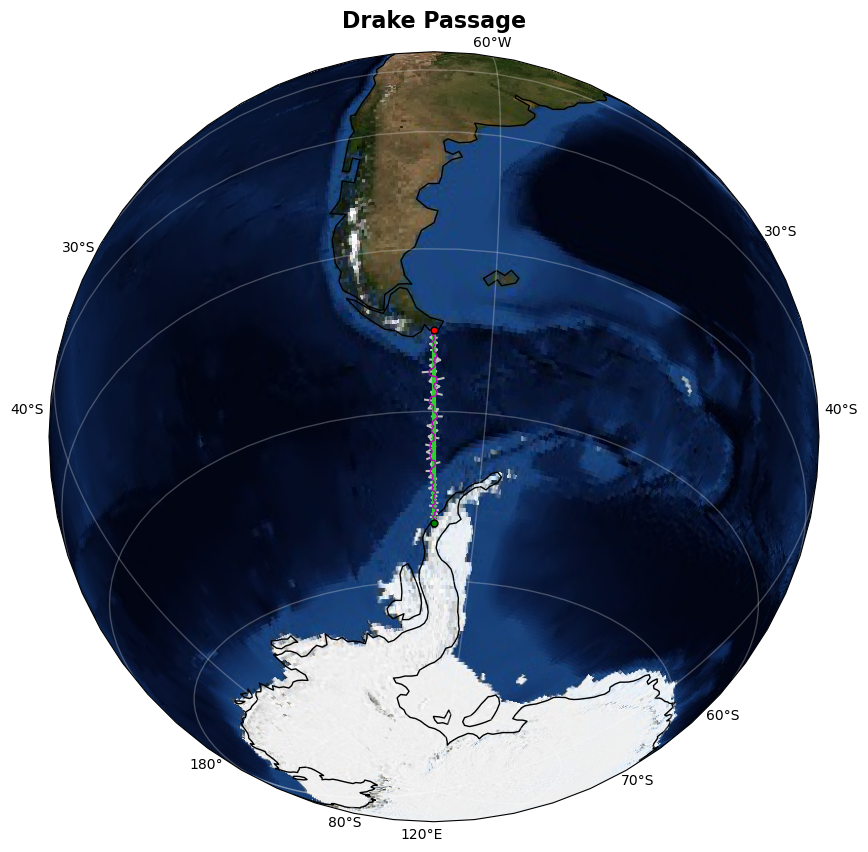

(127, 2)
(126,)


In [5]:
#______________________________________________________________________________________________________    
# load information about edges 
datapath = input_paths[0]
fname    = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    
# load diag file
meshdiag   = xr.open_dataset(os.path.join(dname,fname))
# node indices of edge points [2 x n2ded]
edge       = meshdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri   = meshdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy  = meshdiag['edge_cross_dxdy'].values[:]

# Be sure that the edge_cross_dxdy variable is in the same rotational frame as your velocities. By default
# edge_cross_dxdy is in rotated coordinates. So if you velocities are also in rotated coordinates things are fine.
# If your velocities should be in geo coordinates than edge_cross_dxdy needs to be rotated as well into geo
# coordinates (do_edgevec_r2g=True)
if (do_edgevec_r2g):
    edm_x = mesh.n_x[edge].sum(axis=0)/2.0
    edm_y = mesh.n_y[edge].sum(axis=0)/2.0
    edge_dxdy[0,:], edge_dxdy[1,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[0,:], edge_dxdy[1,:], gridis='geo', do_info=False )
    edge_dxdy[2,:], edge_dxdy[3,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[2,:], edge_dxdy[3,:], gridis='geo', do_info=False )
    del(edm_x, edm_y)
    
# [L]eft  triangle: dx, dy
edge_dxdy_l= np.array([ edge_dxdy[0,:], edge_dxdy[1,:]])
# [R]ight triangle: dx, dy
edge_dxdy_r= np.array([ edge_dxdy[2,:], edge_dxdy[3,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist
del(edge_dxdy)

#______________________________________________________________________________________________________    
# analyse transects computes all neccesary arrays 
transects = tpv.do_analyse_transects(input_transect, mesh, edge, edge_tri, edge_dxdy_l, edge_dxdy_r)
for transect in transects:
    print(transect['Name'])
    fig, ax = tpv.plot_transect_position(mesh, transect, edge=edge, do_grid=False)

print(transect['path_xy'].shape)
print(transect['path_ei'].shape)

In [6]:
list_transects = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None and ref_path != 'None'): yeari, moni, dayi, recordi = year_ref, mon_ref, day_ref, record_ref
    
    #__________________________________________________________________________________________________
    # load data
    data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, descript=descript ,
                                 do_vecrot=False, do_info=False, do_zarithm='None', do_ie2n=False, 
                                 do_nan=False, do_compute=False, )#**{'chunks': {'elem':1e4}})
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    #__________________________________________________________________________________________________
    # compute reference section if given
    if (ii==0) and (ref_path != None and ref_path != 'None'):
        csect_ref = tpv.calc_transect_transp(mesh, data, transects)
        del(data)
        continue
    
    #__________________________________________________________________________________________________
    csect = tpv.calc_transect_transp(mesh, data, transects)
    
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None and ref_path != 'None'): 
        list_transects.append(tpv.do_transect_anomaly(csect, csect_ref))
    # computre absolute     
    else:
        list_transects.append(csect)
if (ref_path != None and ref_path != 'None'): del(csect_ref)        

0 /albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
neto transport: 123.44986682889085  [Sv]
 (+) transport: 167.02433745117668  [Sv]
 (-) transport: -43.57447062228585  [Sv]
        elapsed time: 0.02min.


--> histo: cmin, cmax =  -0.28590115769407076 0.6226501141412375
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -0.29, 'cmax': 0.62, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fa1f092cb50>, 'clevel': array([-0.3  , -0.275, -0.25 , -0.225, -0.2  , -0.175, -0.15 , -0.125,
       -0.1  , -0.075, -0.05 , -0.025,  0.   ,  0.025,  0.05 ,  0.075,
        0.1  ,  0.125,  0.15 ,  0.175,  0.2  ,  0.225,  0.25 ,  0.275,
        0.3  ,  0.325,  0.35 ,  0.375,  0.4  ,  0.425,  0.45 ,  0.475,
        0.5  ,  0.525,  0.55 ,  0.575,  0.6  ,  0.625])}


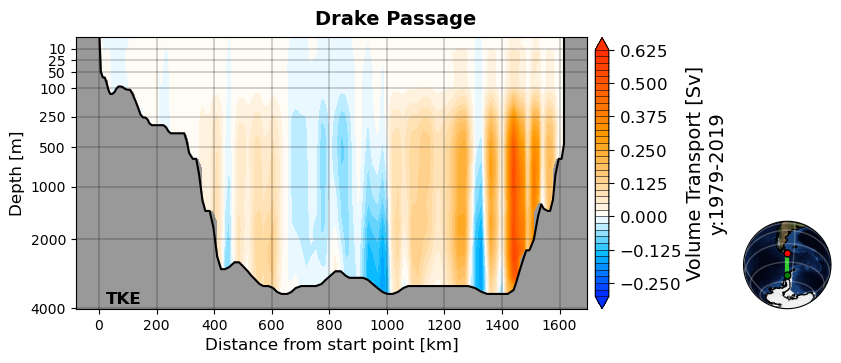

In [8]:
#________________________________________________________________________________________________________
# compute save path
spath  = save_path
sname  = list(list_transects[0][0].keys())[0]
slabel = list_transects[0][0][sname].attrs['str_lsave']
strans = list_transects[0][0][sname].attrs['transect_name'].replace(' ','_').lower()
if spath is not None: spath  = '{}/{}_{}_{}_{}.png'.format(spath, which_mode, sname, strans, slabel) 
ncolumn= np.min([ncolumn,len(list_transects)]) 
nrow   = np.ceil(len(list_transects)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
fig, ax, cbar = tpv.plot_transect(list_transects, transects, cinfo=cinfo, figsize=[ncolumn*figfac[0], nrow*figfac[1]], n_rc=[nrow, ncolumn], 
                                  do_rescale=do_rescale, do_reffig=do_reffig, ref_cinfo=ref_cinfo, ref_rescale=ref_rescale,
                                  do_smooth=True, pos_gap=[0.01, 0.01], pos_extend=[0.10, 0.125, 0.85,0.90], do_ylog=do_ylog, 
                                  do_contour=do_contour, do_position=do_position, mesh=mesh, 
                                  do_save = spath, save_dpi=which_dpi, )